In [1]:
import pydicom
import numpy as np
from dicompylercore import dicomparser, dvh, dvhcalc
import csv
import os
import glob

def get_key(structure_data, name = "x"):
    key = next((key for key, value in structure_data.items() if value["name"].lower() == name), None)
    return key

def calculate_dvh(dose_path, structure_path):
    # Load DICOM files
    rt_dose = dicomparser.DicomParser(dose_path)
    rt_struct = dicomparser.DicomParser(structure_path)
    
    # Extract structure of interest
    structure_data = rt_struct.GetStructures()
    body_roi = None
    for key, value in structure_data.items():
        if value['name'] == "zzPTV":
            body_roi = key
            print(key)
            break
    
    if body_roi is None:
        raise ValueError("Structure 'Body' not found in the RTSTRUCT file.")
    
    # Compute DVH
    dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, body_roi)
    
    if dvh is None:
        raise ValueError("DVH computation failed.")
    
    # Calculate V50Gy (volume receiving at least 50 Gy)
    print(dvh.describe())
    x = dvh.D90
    return x

In [41]:
# Example usage
dose_file = "/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case2/Manual/RD1.2.752.243.1.1.20250306102949096.3300.36122.dcm"
struct_file = "/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case2/Manual/RS1.2.752.243.1.1.20250303133857185.1220.37332.dcm"
v50gy = calculate_dvh(dose_file, struct_file)
print(f"V52.5Gy for zzPTV: {v50gy.value:.2f}%")


49
Structure: zzPTV
-----
DVH Type:  cumulative, abs dose: Gy, abs volume: cm3
Volume:    898.19 cm3
Max Dose:  55.28 Gy
Min Dose:  30.01 Gy
Mean Dose: 51.40 Gy
D100:      30.00 Gy
D98:       47.79 Gy
D95:       49.27 Gy
D2cc:      54.14 Gy
None
V52.5Gy for zzPTV: 50.13%


## Report

In [113]:
# Create a CSV file
report_dir = '/Users/paritt.w/Desktop/Work/AutoBreast/'

if not os.path.exists(report_dir):
        os.makedirs(report_dir)

csv_file = os.path.join(report_dir, 'report.csv')
with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['case', 'plan', 'Body Dmax (Gy)', 'CTV D90% (Gy)', 'CTV D95% (Gy)', 'CTV D98% (Gy)', 
                         'PTV D90% (Gy)', 'PTV D95% (Gy)', 'PTV D98% (Gy)', 'PTV D2% (Gy)', 'PTV V105% (%)', 
                         'Heart Mean (Gy)', 'Heart V20Gy (%)', 'Lt Lung V5Gy (%)', 'Lt Lung V20Gy (%)', 'Rt Lung V5 (%)',
                         'Rt Breast V5Gy (%)', 'Rt Breast Mean (Gy)', 'Rt Breast D2%  (Gy)', 'Thyroid Mean (Gy)'])
        plan = ["Auto","Manual"]
        for i in range(1,11):
                for p in plan:   
                        path = f"/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case {i}/{p}"
                        dose_files = sorted(glob.glob(os.path.join(path, "RD*")))
                        struct_files = sorted(glob.glob(os.path.join(path, "RS*")))
                        dose_file = dose_files[0] if dose_files else None  # Get first file or None
                        struct_file = struct_files[0] if struct_files else None  # Get first file or None
                        print(dose_files)
                        print(struct_file)
                        rt_dose = dicomparser.DicomParser(dose_file)
                        rt_struct = dicomparser.DicomParser(struct_file)
                        structure_data = rt_struct.GetStructures()
                        prescription_dose = 50
        
                        body_key = get_key(structure_data, name = "body")
                        body_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, body_key)
                        body_dmax = body_dvh.max
                        
                        ctv_key = get_key(structure_data, name = "zzctv")
                        ctv_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, ctv_key)
                        ctv_d90 = ctv_dvh.D90.value
                        ctv_d95 = ctv_dvh.D95.value
                        ctv_d98 = ctv_dvh.D98.value
                        
                        ptv_key = get_key(structure_data, name = "zzptv")
                        ptv_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, ptv_key)
                        ptv_dvh.rx_dose = 50
                        ptv_d90 = ptv_dvh.D90.value
                        ptv_d95 = ptv_dvh.D95.value
                        ptv_d98 = ptv_dvh.D98.value
                        ptv_d2 = ptv_dvh.D2.value
                        ptv_v105 = round(((ptv_dvh.V105.value / ptv_dvh.volume)*100),2)
                        
                        heart_key = get_key(structure_data, name = "heart")
                        heart_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, heart_key)
                        heart_mean = heart_dvh.mean
                        heart_v20 = round(((heart_dvh.V20Gy.value / heart_dvh.volume)*100),2)
                        
                        lt_lung_key = get_key(structure_data, name = "lt lung")
                        if lt_lung_key == None: lt_lung_key = get_key(structure_data, name = "lung lt")
                        if lt_lung_key == None: lt_lung_key = get_key(structure_data, name = "lung l")
                        if lt_lung_key == None: lt_lung_key = get_key(structure_data, name = "l lung")
                        lt_lung_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, lt_lung_key)
                        lt_lung_v5 = round(((lt_lung_dvh.V5Gy.value / lt_lung_dvh.volume)*100),2)
                        lt_lung_v20 = round(((lt_lung_dvh.V20Gy.value/lt_lung_dvh.volume)*100),2)
                        
                        rt_lung_key = get_key(structure_data, name = "rt lung")
                        if rt_lung_key == None: rt_lung_key = get_key(structure_data, name = "lung rt")
                        if rt_lung_key == None: rt_lung_key = get_key(structure_data, name = "lung r")
                        if rt_lung_key == None: rt_lung_key = get_key(structure_data, name = "r lung")
                        rt_lung_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, rt_lung_key)
                        rt_lung_v5 = round(((rt_lung_dvh.V5Gy.value / rt_lung_dvh.volume)*100),2)
                        
                        rt_breast_key = get_key(structure_data, name = "rt breast")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "breast rt")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "breast r")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "r breast")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "breast contralateral")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "contralateral breast")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "contralat breast")
                        rt_breast_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, rt_breast_key)
                        rt_breast_v5 = round(((rt_breast_dvh.V5Gy.value / rt_breast_dvh.volume)*100),2)
                        rt_breast_mean = rt_breast_dvh.mean
                        rt_breast_d2 = rt_breast_dvh.D2.value
                        
                        thyroid_key = get_key(structure_data, name = "thyroid gland")
                        if thyroid_key == None: thyroid_key = get_key(structure_data, name = "thyroid")
                        if thyroid_key != None:
                                thyroid_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, thyroid_key)
                                thyroid_mean = thyroid_dvh.mean
                        else:
                                thyroid_mean = "-"
                        
                        writer.writerow([i, p, body_dmax, ctv_d90, ctv_d95, ctv_d98,
                                        ptv_d90, ptv_d95, ptv_d98, ptv_d2, ptv_v105,
                                        heart_mean, heart_v20, lt_lung_v5, lt_lung_v20,
                                        rt_lung_v5, rt_breast_v5,rt_breast_mean,rt_breast_d2, thyroid_mean])

['/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 1/Auto/RD1.2.752.243.1.1.20250303132239839.2320.56342.dcm']
/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 1/Auto/RS1.2.752.243.1.1.20250303132239841.2430.35171.dcm
['/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 1/Manual/RD1.2.752.243.1.1.20250306020742958.4400.36647.dcm']
/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 1/Manual/RS1.2.752.243.1.1.20250303132239841.2430.35171.dcm
['/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 2/Auto/RD1.2.752.243.1.1.20250303133857193.1880.20720.dcm']
/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 2/Auto/RS1.2.752.243.1.1.20250303133857185.1220.37332.dcm
['/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 2/Manual/RD1.2.752.243.1.1.20250306102949096.3300.36122.dcm']
/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 2/Manual/RS1.2.752.243.1.1.20250303133857185.1220.37332.dcm
['/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 3/Auto/RD1.2.752.243.1.1.20250303133046305.1932.35311.dcm']


## Report CCTG-MA39

In [119]:
# Create a CSV file
report_dir = '/Users/paritt.w/Desktop/Work/AutoBreast/'

if not os.path.exists(report_dir):
        os.makedirs(report_dir)

csv_file = os.path.join(report_dir, 'report_CCTG-MA39.csv')
with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['case', 'plan', 'CTV D95% (%)', 'PTV D95% (%)', 'PTV V105 (cc)', 'PTV V107 (cc)', 'PTV V110 (cc)', 'PTV V115 (cc)', 'PTV V120 (cc)',
                         'Ipsilateral Lung V20Gy (%)', 'Ipsilateral Lung V17Gy (%)', 'Ipsilateral Lung V5Gy (%)',
                         'Contralateral Lung V5Gy (%)', 'Contralateral Breast V3Gy (%)', 'Contralateral Breast V5Gy (%)', 
                         'Mean Heart (Gy)', 'Heart V25Gy (%)', 'Heart V30Gy (%)'])
        plan = ["Auto","Manual"]
        for i in range(1,11):
                for p in plan:   
                        path = f"/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case {i}/{p}"
                        dose_files = sorted(glob.glob(os.path.join(path, "RD*")))
                        struct_files = sorted(glob.glob(os.path.join(path, "RS*")))
                        dose_file = dose_files[0] if dose_files else None  # Get first file or None
                        struct_file = struct_files[0] if struct_files else None  # Get first file or None
                        print(dose_files)
                        print(struct_file)
                        rt_dose = dicomparser.DicomParser(dose_file)
                        rt_struct = dicomparser.DicomParser(struct_file)
                        structure_data = rt_struct.GetStructures()
                        prescription_dose = 50
                        
                        ctv_key = get_key(structure_data, name = "zzctv")
                        ctv_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, ctv_key)
                        ctv_d95 = round((ctv_dvh.D95.value/prescription_dose)*100,2)
                        
                        ptv_key = get_key(structure_data, name = "zzptv")
                        ptv_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, ptv_key)
                        ptv_dvh.rx_dose = 50
                        ptv_d95 = round((ptv_dvh.D95.value/prescription_dose)*100,2)
                        ptv_v105 = ptv_dvh.V105.value
                        ptv_v107 = ptv_dvh.V107.value
                        ptv_v110 = ptv_dvh.V110.value
                        ptv_v115 = ptv_dvh.V115.value
                        ptv_v120 = ptv_dvh.V120.value
                        
                        lt_lung_key = get_key(structure_data, name = "lt lung")
                        if lt_lung_key == None: lt_lung_key = get_key(structure_data, name = "lung lt")
                        if lt_lung_key == None: lt_lung_key = get_key(structure_data, name = "lung l")
                        if lt_lung_key == None: lt_lung_key = get_key(structure_data, name = "l lung")
                        lt_lung_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, lt_lung_key)
                        lt_lung_v20 = round(((lt_lung_dvh.V20Gy.value/lt_lung_dvh.volume)*100),2)
                        lt_lung_v17 = round(((lt_lung_dvh.V17Gy.value/lt_lung_dvh.volume)*100),2)
                        lt_lung_v5 = round(((lt_lung_dvh.V5Gy.value / lt_lung_dvh.volume)*100),2)
                        
                        
                        rt_lung_key = get_key(structure_data, name = "rt lung")
                        if rt_lung_key == None: rt_lung_key = get_key(structure_data, name = "lung rt")
                        if rt_lung_key == None: rt_lung_key = get_key(structure_data, name = "lung r")
                        if rt_lung_key == None: rt_lung_key = get_key(structure_data, name = "r lung")
                        rt_lung_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, rt_lung_key)
                        rt_lung_v5 = round(((rt_lung_dvh.V5Gy.value / rt_lung_dvh.volume)*100),2)
                        
                        rt_breast_key = get_key(structure_data, name = "rt breast")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "breast rt")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "breast r")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "r breast")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "breast contralateral")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "contralateral breast")
                        if rt_breast_key == None: rt_breast_key = get_key(structure_data, name = "contralat breast")
                        rt_breast_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, rt_breast_key)
                        rt_breast_v3 = round(((rt_breast_dvh.V3Gy.value / rt_breast_dvh.volume)*100),2)
                        rt_breast_v5 = round(((rt_breast_dvh.V5Gy.value / rt_breast_dvh.volume)*100),2)
                        
                        heart_key = get_key(structure_data, name = "heart")
                        heart_dvh = dvhcalc.get_dvh(rt_struct.ds, rt_dose.ds, heart_key)
                        heart_mean = heart_dvh.mean
                        heart_v25 = round(((heart_dvh.V25Gy.value / heart_dvh.volume)*100),2)
                        heart_v30 = round(((heart_dvh.V30Gy.value / heart_dvh.volume)*100),2)
                        
                        writer.writerow([i, p, ctv_d95, ptv_d95, ptv_v105, ptv_v107, ptv_v110, ptv_v115, ptv_v120,
                                         lt_lung_v20, lt_lung_v17,lt_lung_v5, 
                                         rt_lung_v5, rt_breast_v3, rt_breast_v5,
                                         heart_mean, heart_v25, heart_v30])

['/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 1/Auto/RD1.2.752.243.1.1.20250303132239839.2320.56342.dcm']
/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 1/Auto/RS1.2.752.243.1.1.20250303132239841.2430.35171.dcm
['/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 1/Manual/RD1.2.752.243.1.1.20250306020742958.4400.36647.dcm']
/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 1/Manual/RS1.2.752.243.1.1.20250303132239841.2430.35171.dcm
['/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 2/Auto/RD1.2.752.243.1.1.20250303133857193.1880.20720.dcm']
/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 2/Auto/RS1.2.752.243.1.1.20250303133857185.1220.37332.dcm
['/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 2/Manual/RD1.2.752.243.1.1.20250306102949096.3300.36122.dcm']
/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 2/Manual/RS1.2.752.243.1.1.20250303133857185.1220.37332.dcm
['/Users/paritt.w/Desktop/Work/AutoBreast/Data/Case 3/Auto/RD1.2.752.243.1.1.20250303133046305.1932.35311.dcm']


# Stat test

## Wilcoxon or T-test

In [114]:
from scipy import stats
import pandas as pd

df = pd.read_csv('/Users/paritt.w/Desktop/Work/AutoBreast/report.csv')

with open(f'/Users/paritt.w/Desktop/Work/AutoBreast/stat_result.txt', "w") as file:
    for i in range(2,19):
        metric = df.columns[i]
        auto = np.abs(np.array(df[df['plan'] == 'Auto'][metric]))
        manual = np.abs(np.array(df[df['plan'] == 'Manual'][metric]))
        diff = auto - manual
        shapiro_stat, shapiro_p = stats.shapiro(diff)
        if shapiro_p < 0.05:
            stat, p = stats.wilcoxon(auto, manual)
            if p < 0.05:
                print(f'{metric} [Wilcoxon test] \nSignificant \n{round(p,4)}', file=file)
            else:
                print(f'{metric} [Wilcoxon test] \nNOT Significant \n{round(p,4)}', file=file)
        else:
            t_statistic, p = stats.ttest_rel(auto, manual)
            if p < 0.05:
                print(f'{metric} [Pair T-test] \nSignificant \n{round(p,4)}', file=file)
            else:
                print(f'{metric} [Pair T-test] \nNOT Significant \n{round(p,4)}', file=file)
        print('\n', file=file)


## T-test only

In [115]:
from scipy import stats
import pandas as pd

df = pd.read_csv('/Users/paritt.w/Desktop/Work/AutoBreast/report.csv')

with open(f'/Users/paritt.w/Desktop/Work/AutoBreast/t-test_result.txt', "w") as file:
    for i in range(2,19):
        metric = df.columns[i]
        auto = np.abs(np.array(df[df['plan'] == 'Auto'][metric]))
        manual = np.abs(np.array(df[df['plan'] == 'Manual'][metric]))
        t_statistic, p = stats.ttest_rel(auto, manual)
        if p < 0.05:
            print(f'{metric} [Pair T-test] \nSignificant \n{round(p,4)}', file=file)
        else:
            print(f'{metric} [Pair T-test] \nNOT Significant \n{round(p,4)}', file=file)
        print('\n', file=file)


In [121]:
from scipy import stats
import pandas as pd

df = pd.read_csv('/Users/paritt.w/Desktop/Work/AutoBreast/report_CCTG-MA39.csv')

with open(f'/Users/paritt.w/Desktop/Work/AutoBreast/t-test_result_CCTG-MA39.txt', "w") as file:
    for i in range(2,18):
        metric = df.columns[i]
        auto = np.abs(np.array(df[df['plan'] == 'Auto'][metric]))
        manual = np.abs(np.array(df[df['plan'] == 'Manual'][metric]))
        t_statistic, p = stats.ttest_rel(auto, manual)
        if p < 0.05:
            print(f'{metric} [Pair T-test] \nSignificant \n{round(p,4)}', file=file)
        else:
            print(f'{metric} [Pair T-test] \nNOT Significant \n{round(p,4)}', file=file)
        print('\n', file=file)


# Stat Analyze

In [153]:
# Create a CSV file
report_dir = '/Users/paritt.w/Desktop/Work/AutoBreast/'

if not os.path.exists(report_dir):
        os.makedirs(report_dir)

csv_file = os.path.join(report_dir, 'analyze_result_CCTG-MA39.csv')
df = pd.read_csv('/Users/paritt.w/Desktop/Work/AutoBreast/report_CCTG-MA39.csv')
with open(csv_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow([i for i in df.columns[0:18]])
        plan = ["Auto","Manual"]
        for p in plan:
                max_set = ["max"]
                mean_set = ["mean"]
                min_set = ["min"]
                sd_set = ["SD"]
                max_set.append(p)
                mean_set.append(p)
                min_set.append(p)
                sd_set.append(p)
                for i in range(2,18):
                        metric = df.columns[i]
                        plan = np.abs(np.array(df[df['plan'] == p][metric]))
                        max_value = max(plan)
                        max_set.append(max_value)
                        mean_value = np.mean(plan)
                        mean_set.append(mean_value)
                        min_value = np.min(plan)
                        min_set.append(min_value)
                        sd_value = np.std(plan)
                        sd_set.append(sd_value)
                writer.writerow([i for i in max_set])
                writer.writerow([i for i in mean_set])
                writer.writerow([i for i in min_set])
                writer.writerow([i for i in sd_set])

# Plot

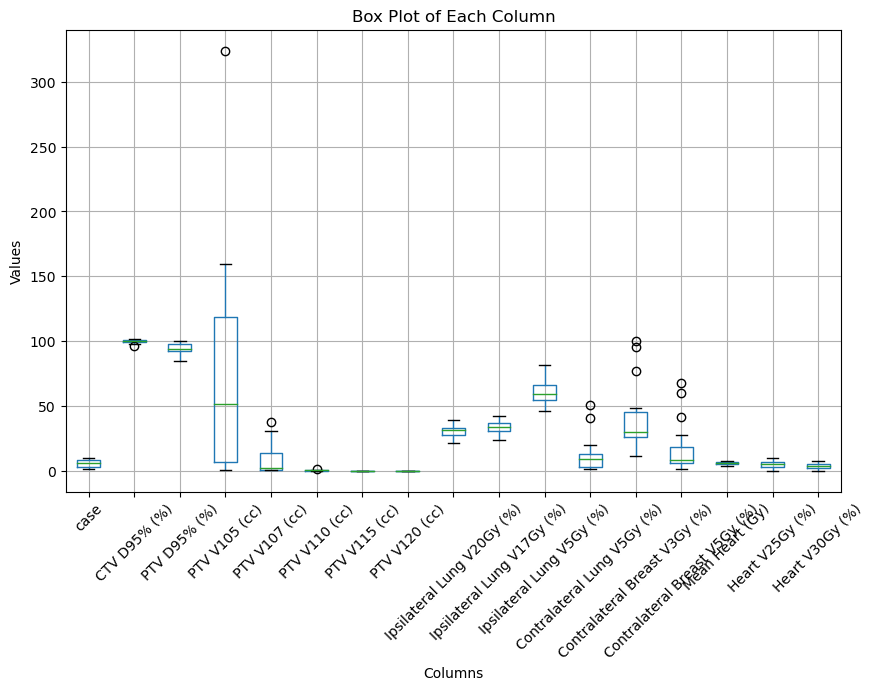

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

csv_file = '/Users/paritt.w/Desktop/Work/AutoBreast/report_CCTG-MA39.csv'
df = pd.read_csv(csv_file)

# Plot box plot
plt.figure(figsize=(10, 6))
df.boxplot()

# Customize plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.title("Box Plot of Each Column")
plt.xlabel("Columns")
plt.ylabel("Values")

# Show plot
plt.show()

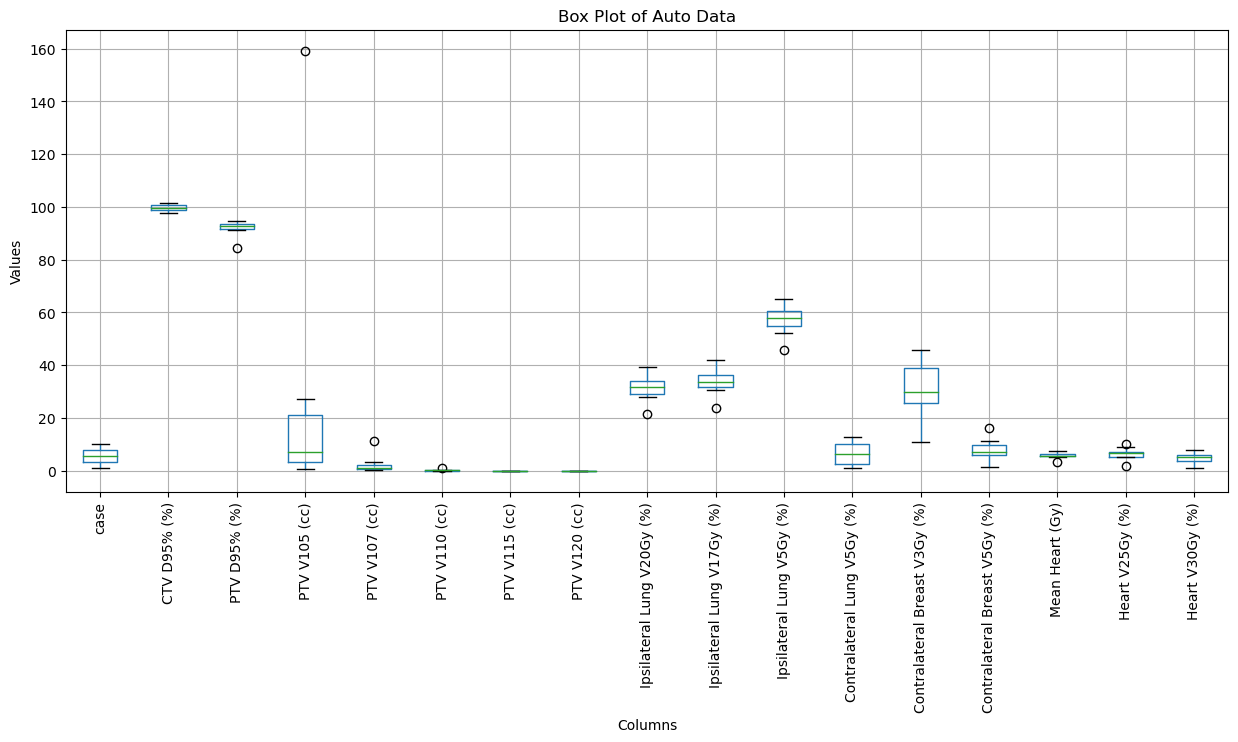

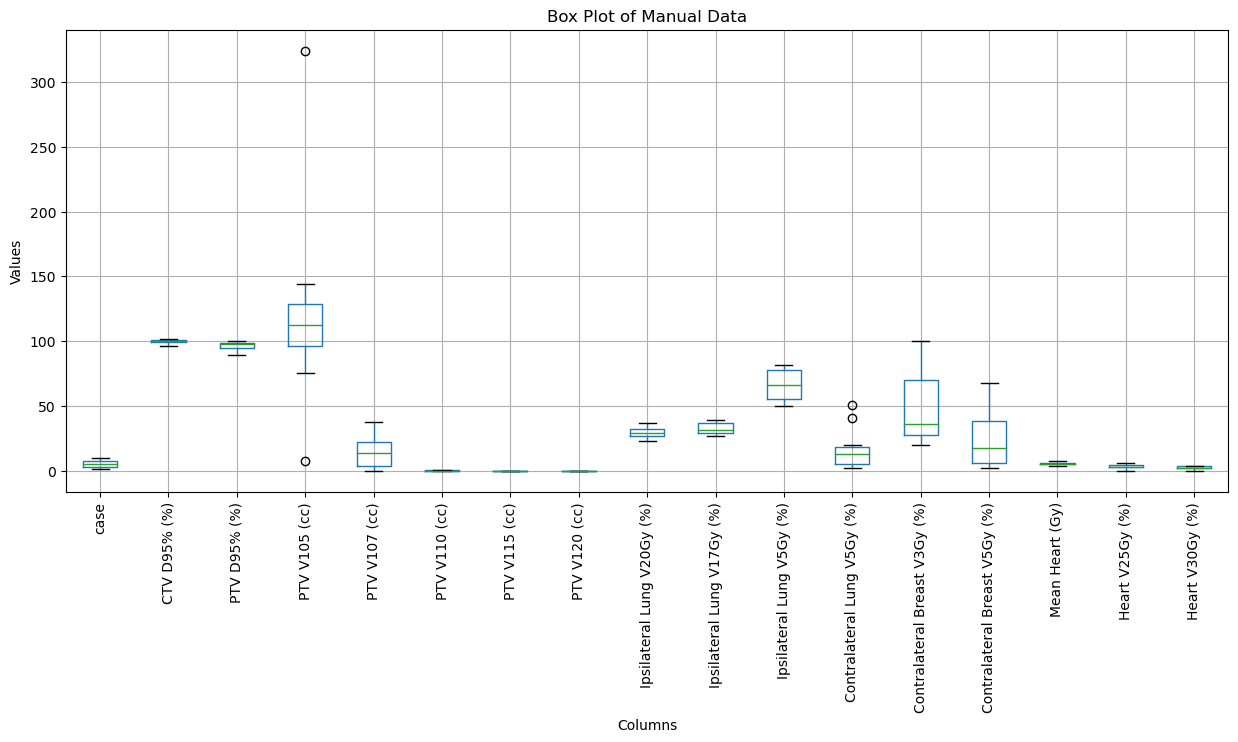

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
csv_file = '/Users/paritt.w/Desktop/Work/AutoBreast/report_CCTG-MA39.csv'
df = pd.read_csv(csv_file)

# Split data into "Auto" and "Manual"
auto_df = df[df["plan"] == "Auto"]
manual_df = df[df["plan"] == "Manual"]

# Drop non-numeric columns for box plot
numeric_cols = df.select_dtypes(include="number").columns

# Plot Auto data
plt.figure(figsize=(15, 6))
auto_df[numeric_cols].boxplot()
plt.title("Box Plot of Auto Data")
plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Values")
plt.show()

# Plot Manual data
plt.figure(figsize=(15, 6))
manual_df[numeric_cols].boxplot()
plt.title("Box Plot of Manual Data")
plt.xticks(rotation=90)
plt.xlabel("Columns")
plt.ylabel("Values")
plt.show()


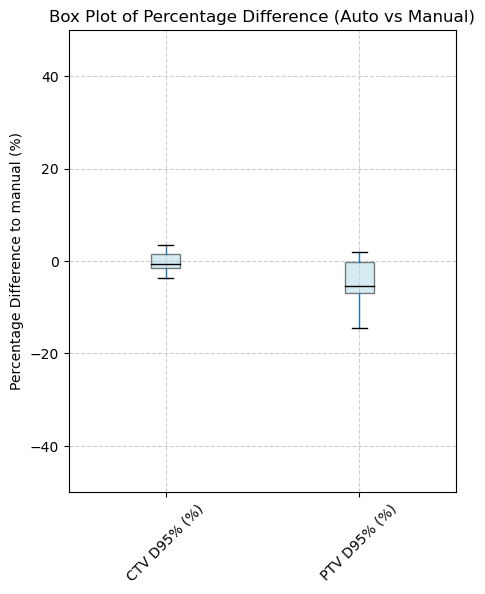

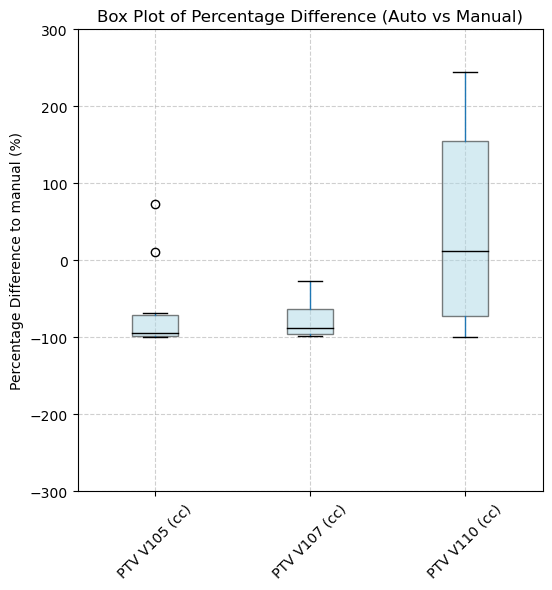

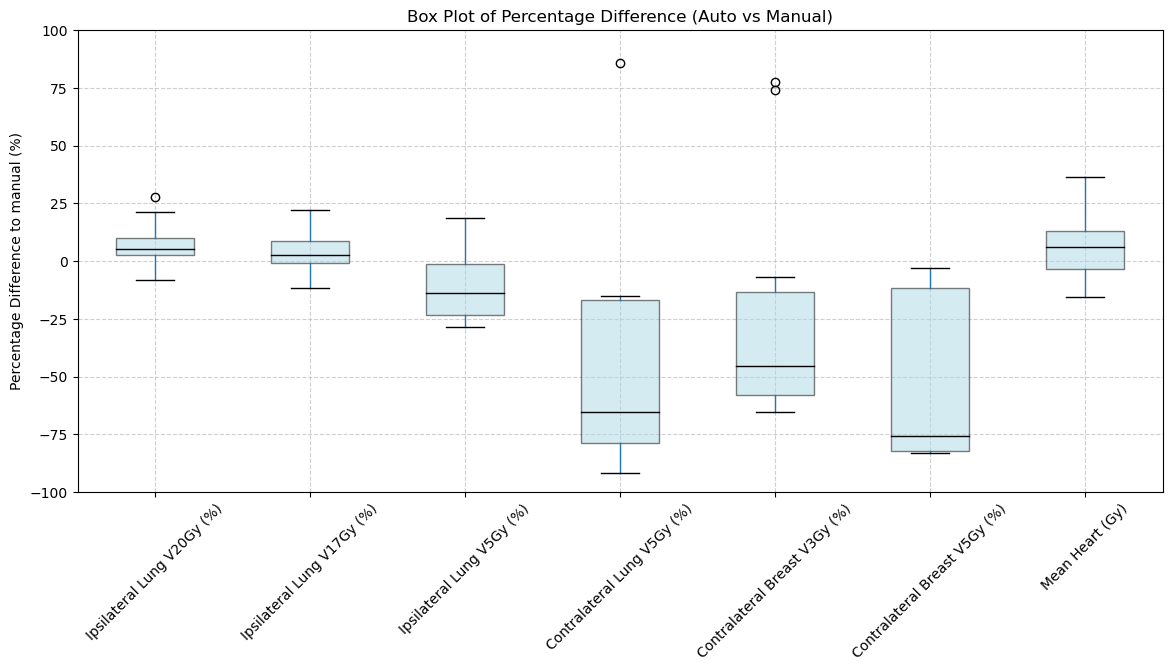

In [58]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
csv_file = "/Users/paritt.w/Desktop/Work/AutoBreast/report_CCTG-MA39.csv"
df = pd.read_csv(csv_file)

# Split data into "Auto" and "Manual"
auto_df = df[df["plan"] == "Auto"].iloc[:, 2:4].reset_index(drop=True)
manual_df = df[df["plan"] == "Manual"].iloc[:, 2:4].reset_index(drop=True)

# Convert data to numeric (ignores non-numeric values)
auto_df = auto_df.apply(pd.to_numeric, errors="coerce")
manual_df = manual_df.apply(pd.to_numeric, errors="coerce")

# Calculate percentage difference
percentage_diff = ((auto_df - manual_df) / manual_df) * 100

# Set y-axis limits (adjust as needed)
y_min, y_max = -50, 50

# Create box plot
plt.figure(figsize=(5, 6))
percentage_diff.boxplot(
    patch_artist=True,  # Fill color
    boxprops=dict(facecolor="lightblue", alpha=0.5),
    medianprops=dict(color="black")
)

# Set labels and title
plt.ylim(y_min, y_max)
plt.xticks(range(1, len(percentage_diff.columns) + 1), percentage_diff.columns, rotation=45)
#plt.xlabel("Columns")
plt.ylabel("Percentage Difference to manual (%)")
plt.title("Box Plot of Percentage Difference (Auto vs Manual)")
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


# Split data into "Auto" and "Manual"
auto_df = df[df["plan"] == "Auto"].iloc[:, 4:7].reset_index(drop=True)
manual_df = df[df["plan"] == "Manual"].iloc[:, 4:7].reset_index(drop=True)

# Convert data to numeric (ignores non-numeric values)
auto_df = auto_df.apply(pd.to_numeric, errors="coerce")
manual_df = manual_df.apply(pd.to_numeric, errors="coerce")

# Calculate percentage difference
percentage_diff = ((auto_df - manual_df) / manual_df) * 100

# Set y-axis limits (adjust as needed)
y_min, y_max = -300, 300

# Create box plot
plt.figure(figsize=(6, 6))
percentage_diff.boxplot(
    patch_artist=True,  # Fill color
    boxprops=dict(facecolor="lightblue", alpha=0.5),
    medianprops=dict(color="black")
)

# Set labels and title
plt.ylim(y_min, y_max)
plt.xticks(range(1, len(percentage_diff.columns) + 1), percentage_diff.columns, rotation=45)
#plt.xlabel("Columns")
plt.ylabel("Percentage Difference to manual (%)")
plt.title("Box Plot of Percentage Difference (Auto vs Manual)")
plt.grid(True, linestyle="--", alpha=0.6)


# Show plot
plt.show()


# Split data into "Auto" and "Manual"
auto_df = df[df["plan"] == "Auto"].iloc[:, 9:16].reset_index(drop=True)
manual_df = df[df["plan"] == "Manual"].iloc[:, 9:16].reset_index(drop=True)

# Convert data to numeric (ignores non-numeric values)
auto_df = auto_df.apply(pd.to_numeric, errors="coerce")
manual_df = manual_df.apply(pd.to_numeric, errors="coerce")

# Calculate percentage difference
percentage_diff = ((auto_df - manual_df) / manual_df) * 100

# Set y-axis limits (adjust as needed)
y_min, y_max = -100, 100

# Create box plot
plt.figure(figsize=(14, 6))
percentage_diff.boxplot(
    patch_artist=True,  # Fill color
    boxprops=dict(facecolor="lightblue", alpha=0.5),
    medianprops=dict(color="black")
)

# Set labels and title
plt.ylim(y_min, y_max)
plt.xticks(range(1, len(percentage_diff.columns) + 1), percentage_diff.columns, rotation=45)
#plt.xlabel("Columns")
plt.ylabel("Percentage Difference to manual (%)")
plt.title("Box Plot of Percentage Difference (Auto vs Manual)")
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()



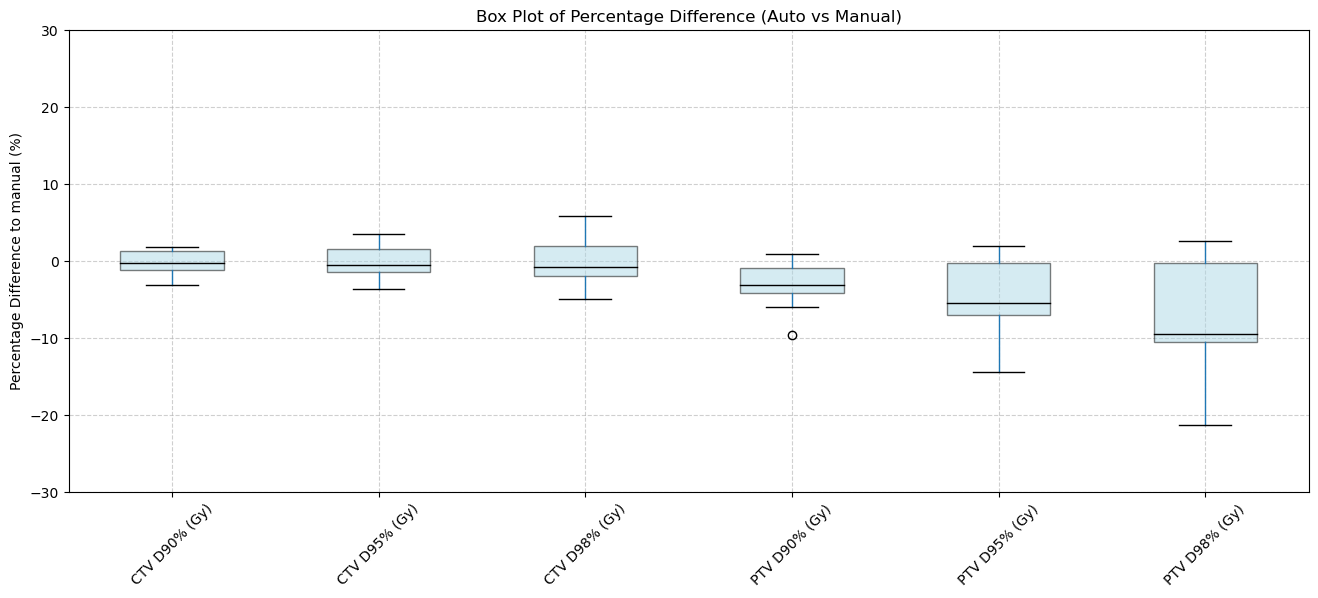

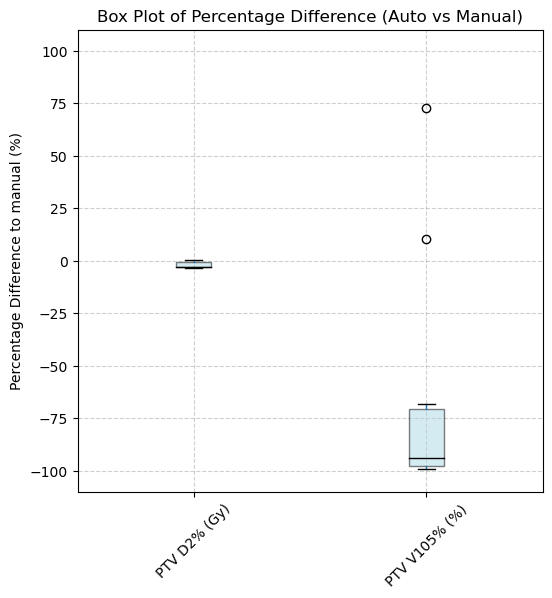

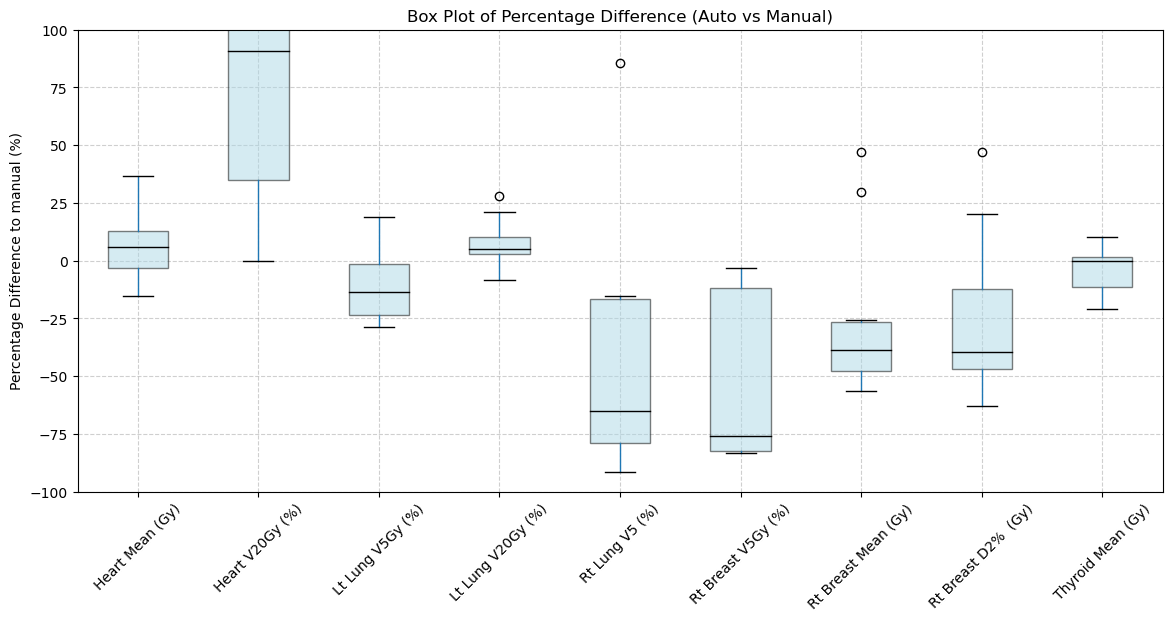

In [76]:
import pandas as pd
import matplotlib.pyplot as plt

# Load CSV file
csv_file = "/Users/paritt.w/Desktop/Work/AutoBreast/report.csv"
df = pd.read_csv(csv_file)

# Split data into "Auto" and "Manual"
auto_df = df[df["plan"] == "Auto"].iloc[:, 3:9].reset_index(drop=True)
manual_df = df[df["plan"] == "Manual"].iloc[:, 3:9].reset_index(drop=True)

# Convert data to numeric (ignores non-numeric values)
auto_df = auto_df.apply(pd.to_numeric, errors="coerce")
manual_df = manual_df.apply(pd.to_numeric, errors="coerce")

# Calculate percentage difference
percentage_diff = ((auto_df - manual_df) / manual_df) * 100

# Set y-axis limits (adjust as needed)
y_min, y_max = -30, 30

# Create box plot
plt.figure(figsize=(16, 6))
percentage_diff.boxplot(
    patch_artist=True,  # Fill color
    boxprops=dict(facecolor="lightblue", alpha=0.5),
    medianprops=dict(color="black")
)

# Set labels and title
plt.ylim(y_min, y_max)
plt.xticks(range(1, len(percentage_diff.columns) + 1), percentage_diff.columns, rotation=45)
#plt.xlabel("Columns")
plt.ylabel("Percentage Difference to manual (%)")
plt.title("Box Plot of Percentage Difference (Auto vs Manual)")
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()


# Split data into "Auto" and "Manual"
auto_df = df[df["plan"] == "Auto"].iloc[:, 9:11].reset_index(drop=True)
manual_df = df[df["plan"] == "Manual"].iloc[:, 9:11].reset_index(drop=True)

# Convert data to numeric (ignores non-numeric values)
auto_df = auto_df.apply(pd.to_numeric, errors="coerce")
manual_df = manual_df.apply(pd.to_numeric, errors="coerce")

# Calculate percentage difference
percentage_diff = ((auto_df - manual_df) / manual_df) * 100

# Set y-axis limits (adjust as needed)
y_min, y_max = -110, 110

# Create box plot
plt.figure(figsize=(6, 6))
percentage_diff.boxplot(
    patch_artist=True,  # Fill color
    boxprops=dict(facecolor="lightblue", alpha=0.5),
    medianprops=dict(color="black")
)

# Set labels and title
plt.ylim(y_min, y_max)
plt.xticks(range(1, len(percentage_diff.columns) + 1), percentage_diff.columns, rotation=45)
#plt.xlabel("Columns")
plt.ylabel("Percentage Difference to manual (%)")
plt.title("Box Plot of Percentage Difference (Auto vs Manual)")
plt.grid(True, linestyle="--", alpha=0.6)


# Show plot
plt.show()


# Split data into "Auto" and "Manual"
auto_df = df[df["plan"] == "Auto"].iloc[:, 11:].reset_index(drop=True)
manual_df = df[df["plan"] == "Manual"].iloc[:, 11:].reset_index(drop=True)

# Convert data to numeric (ignores non-numeric values)
auto_df = auto_df.apply(pd.to_numeric, errors="coerce")
manual_df = manual_df.apply(pd.to_numeric, errors="coerce")

# Calculate percentage difference
percentage_diff = ((auto_df - manual_df) / manual_df) * 100

# Set y-axis limits (adjust as needed)
y_min, y_max = -100, 100

# Create box plot
plt.figure(figsize=(14, 6))
percentage_diff.boxplot(
    patch_artist=True,  # Fill color
    boxprops=dict(facecolor="lightblue", alpha=0.5),
    medianprops=dict(color="black")
)

# Set labels and title
plt.ylim(y_min, y_max)
plt.xticks(range(1, len(percentage_diff.columns) + 1), percentage_diff.columns, rotation=45)
#plt.xlabel("Columns")
plt.ylabel("Percentage Difference to manual (%)")
plt.title("Box Plot of Percentage Difference (Auto vs Manual)")
plt.grid(True, linestyle="--", alpha=0.6)

# Show plot
plt.show()

